In [ ]:
#Une fois le dataframe complet optimisé, on peut mener l'analyse en stats descriptives

In [36]:
#Lib
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import calendar

In [37]:
#LISTE DES STATS DES POSSIBLES

#Observations générales
'''
- boxplots
- describe/summary (uniquement pour les colonnes : scores, note moyenne, nb votes, durée)
'''

#Calculs d'effectifs/répartition/proportions
'''
- Evolution dans le temps des effectifs de film produits
- groupby month => effectifs de films produits en fonction de la période de l'année
- recoder les var quanti en déciles
'''

#Plots 
'''
- est-ce que les films moins connus sont mieux notés ? (corrélation négative entre Note_moyenne et Nb_votes ?)
- Note_moyenne en fonction de la durée
- Note_moyenne en fonction des genres (histogramme)
- Note_moyenne en fonction du mois
- Note_moyenne en fonction des scores (actors and directors)
'''

'\n- est-ce que les films moins connus sont mieux notés ? (corrélation négative entre Note_moyenne et Nb_votes ?)\n- Note_moyenne en fonction de la durée\n- Note_moyenne en fonction des genres (histogramme)\n- Note_moyenne en fonction du mois\n- Note_moyenne en fonction des scores (actors and directors)\n'

In [39]:
#récupérer la base de données complète
movies_rating = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz")
movies_rating_clean = movies_rating["tconst\taverageRating\tnumVotes"].str.split("\\t", expand=True)
movies_rating_clean.columns = ['ID', 'Note_moyenne', 'Nombre_de_votes']
movies_rating_clean['Note_moyenne'] = movies_rating_clean['Note_moyenne'].astype(float)
movies_rating_clean['Nombre_de_votes'] = movies_rating_clean['Nombre_de_votes'].astype(float)
movies_rating_filtré = movies_rating_clean[movies_rating_clean.Nombre_de_votes > 1999]

df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/Succes_de_films-IMDb/main/Database/IMDB_2000votes.csv', 
                 converters={"actor": lambda x: x.strip("[]").split(", "), 'director': lambda y : y.strip("[]").split(", "),"genre": lambda x: x.strip("[]").split(", ")}) 

movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
df_fusionné = df.merge(movies_rating_filtré, on='url',how='left')

df_fusionné = df_fusionné.reindex(columns=['ID_y','name','alternateName','url','contentRating','datePublished','genre','actor','director','creator','Origine','Budget','duration','keywords','Note_moyenne','Nombre_de_votes','ID_x'])	
df_fusionné =df_fusionné.drop(['ID_x', 'Budget', 'alternateName', 'creator'],axis=1) #On drop creator, pour les questions de scrap évoquées plus tôt, et budget parce qu'il est 
df_fusionné.rename(columns={'ID_y':'ID'}, inplace= True)




#recodage mois + création colonne mois en français
index_with_nan = df.index[df_fusionné.loc[:,'datePublished'].isnull()]
df_fusionné.drop(index_with_nan,0, inplace=True)

df_fusionné['month'] = pd.DatetimeIndex(df_fusionné['datePublished']).month
df_fusionné['month'] = df_fusionné['month'].astype(int)
df_fusionné['month_name'] = df_fusionné['month'].apply(lambda x: calendar.month_abbr[x])



#corrections
def correcteur(colonne, old, new) :
    if type(df_fusionné[colonne][0]) == list :
        all_crews = []
        for crew in df_fusionné[colonne]:
            crew_corrigé = []
            if crew != [] :
                for individu in crew :
                    crew_corrigé.append(individu.replace(old, new))
            all_crews.append(crew_corrigé)
        df_fusionné[colonne] = all_crews
    else :
        df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new, case = False)
        
correcteur('actor', '&apos;', "'")
correcteur('director', '&apos;', "'")
correcteur('name', '&apos;', "'")

from pandas.core.common import flatten

print(type(df_fusionné['genre']))
def valeurs_possibles (colonne) :
    list_nonflat = df_fusionné[colonne]
    flat_list = list(flatten(list_nonflat))
    liste_valeurs = list(set(flat_list))
    return liste_valeurs

/tmp/ipykernel_126/1163823738.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
/tmp/ipykernel_126/1163823738.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fusionné.drop(index_with_nan,0, inplace=True)


<class 'pandas.core.series.Series'>


In [82]:
df_fusionné.head(10)
df_fusionné['month_name']

32016    Jun
14624    Oct
0        May
1        Jan
10983    Aug
        ... 
26294    Jan
26595    Feb
25822    Mar
39068    Mar
27659    Sep
Name: month_name, Length: 46081, dtype: object

In [126]:
# OBSERVATIONS GENERALES DES VAR QUANTI

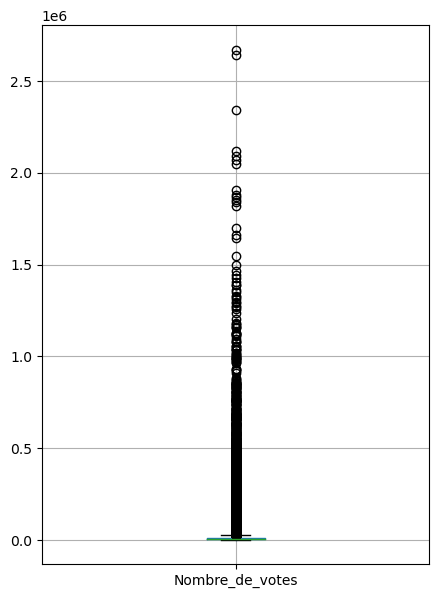

In [18]:
#boxplots (attention il faut pas les lancer les 2 en mm temps)
df_fusionné.boxplot(column=['Nombre_de_votes'], figsize=(5,7)) #bof, voir si on peut faire qqch pour pouvoir changer l'échelle
plt.show()

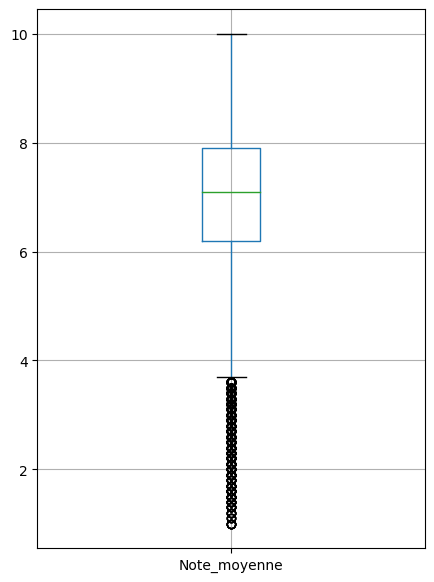

In [19]:
df_fusionné.boxplot(column=['Note_moyenne'], figsize=(5,7))
plt.show()

In [9]:
#tableau stats générales : scores, note moyenne, nb votes, durée (à rajouter)
df_fusionné[['Note_moyenne','Nombre_de_votes']].describe()

,Note_moyenne,Nombre_de_votes
count,46080.000000,4.608000e+04
mean,6.983676,2.524384e+04
std,1.303909,8.690345e+04
min,1.000000,2.000000e+03
25%,6.200000,2.905000e+03
50%,7.100000,4.707500e+03
75%,7.900000,1.256100e+04
max,10.000000,2.671572e+06


In [ ]:
# EFFECTIFS / DISTRIBUTION DES PROPORTIONS

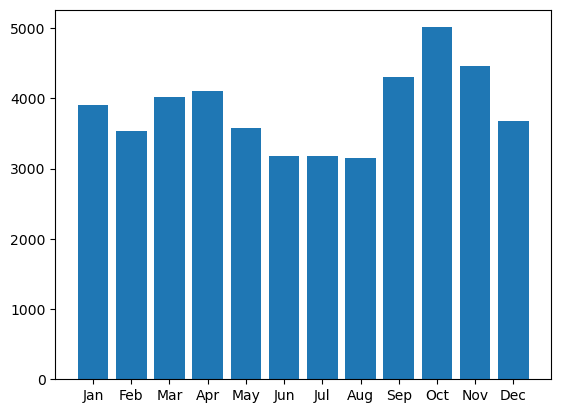

In [20]:
# Nb films sortis par mois
films_par_mois = df_fusionné.groupby('month_name')['ID'].count().rename_axis('month_name').reset_index(name='nb_films')
films_par_mois = films_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

notes_par_mois = df_fusionné.groupby('month_name')['Note_moyenne'].mean().rename_axis('month_name').reset_index(name='note_moyenne')
notes_par_mois = notes_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

plt.bar(films_par_mois['month_name'],films_par_mois['nb_films'])
plt.bar(notes_par_mois['month_name'],notes_par_mois['note_moyenne'])
plt.show()

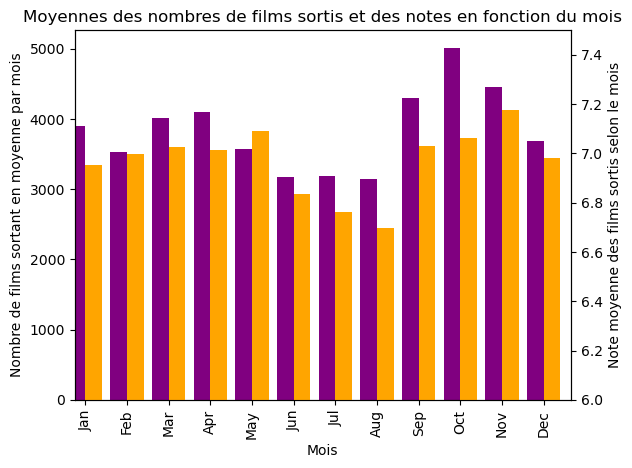

In [22]:
#les deux sur le même
#jointure des deux tableaux d'abord
nb_notes_par_mois = films_par_mois.merge(notes_par_mois,on='month_name',how='left')
nb_notes_par_mois = nb_notes_par_mois.set_index('month_name')
nb_notes_par_mois

#puis le graphe
graph = plt.figure()

ax = graph.add_subplot(111)
ax2 = ax.twinx()

nb_notes_par_mois['nb_films'].plot(kind='bar',color='purple',ax=ax,width=0.4,position = 1)
nb_notes_par_mois['note_moyenne'].plot(kind='bar',color='orange',ax=ax2,width=0.4,position = 0)
ax.set_ylabel('Nombre de films sortant en moyenne par mois')
ax.set_xlabel('Mois')
ax2.set(ylim=[6,7.5], ylabel = 'Note moyenne des films sortis selon le mois')
plt.title('Moyennes des nombres de films sortis et des notes en fonction du mois')
plt.show()

In [148]:
# Note moyenne par décile de films
df_fusionné.groupby(pd.qcut(df_fusionné['ID'], 10))['Note_moyenne'].mean()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<AxesSubplot: >

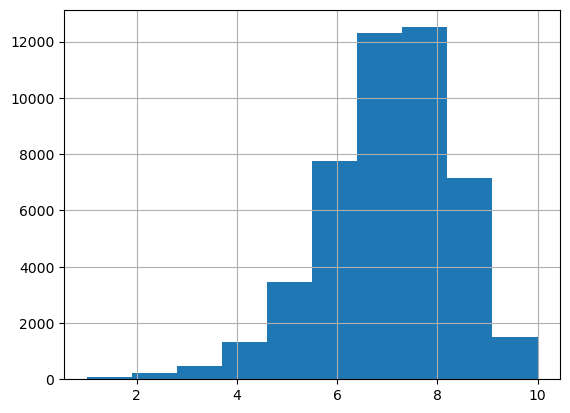

In [5]:
df_fusionné['Note_moyenne'].hist()

In [6]:
df_fusionné.groupby('Origine').mean()

/tmp/ipykernel_128/2106022310.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_fusionné.groupby('Origine').mean()


,Note_moyenne,Nombre_de_votes
Origine,,
Albania,6.800000,2005.000000
Argentina,6.725714,9917.971429
Armenia,6.033333,9292.666667
Aruba,4.100000,4807.000000
Australia,6.578049,7724.222997
...,...,...
Venezuela,7.025000,4385.500000
Vietnam,5.500000,6168.384615
West Germany,6.324390,4345.707317


In [ ]:
df_fusionné.groupby('month').mean()

In [ ]:
df_fusionné.groupby(['month','Origine']).mean()

In [40]:
def recodage_duree(duree) :
    if type(duree) == str :
        duree = duree[2:]
        if 'H' not in duree :
            duree_corrigee = int(duree[-3:-1])
        elif 'M' not in duree :
            duree_corrigee = int(duree[-2:-1])*60
        else :
            heures = int(duree[0])*60
            duree = duree[2:]
            minutes = int(duree[-3:-1])
            duree_corrigee = heures + minutes
    else :
        duree_corrigee = None
    return duree_corrigee

In [41]:
df_fusionné['duration']=df_fusionné['duration'].apply(lambda row : recodage_duree(row))

In [42]:
df_fusionné

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month,month_name
0,tt0000005,Blacksmith Scene,/title/tt0000005/,Unrated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,"blacksmith,national film registry,beer,two wor...",6.2,2556.0,5,May
1,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,"national film registry,year 1894,1890s,19th ce...",5.4,2073.0,1,Jan
2,tt0000010,La sortie de l'usine Lumière à Lyon,/title/tt0000010/,Not Rated,1895-03-22,"['Documentary', 'Short']",[],['Louis Lumière'],France,1.0,"reference to lumiere brothers,reference to the...",6.9,6999.0,3,Mar
3,tt0000012,L'arrivée d'un train à La Ciotat,/title/tt0000012/,Not Rated,1896-01-25,"['Documentary', 'Short']","['Madeleine Koehler', 'Marcel Koehler', 'Mrs. ...","['Auguste Lumière', 'Louis Lumière']",France,1.0,"actuality film,year 1896,train,train station,1...",7.4,12005.0,1,Jan
6,tt0000070,Démolition d'un mur,/title/tt0000070/,Not Rated,1896-03-06,"['Documentary', 'Short']",['Auguste Lumière'],['Louis Lumière'],France,1.0,"year 1896,demolition,1890s,19th century",6.4,2596.0,3,Mar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46779,tt9913038,Together Forever,/title/tt9913038/,TV-MA,2019-06-08,"['Animation', 'Action', 'Adventure']","['Natsuki Hanae', 'Akari Kitô', 'Hiro Shimono']","['Haruo Sotozaki', 'Yûki Itô']",Japan,24.0,NaN,8.5,2815.0,6,Jun
46780,tt9913040,Tsuzumi Mansion,/title/tt9913040/,TV-14,2019-06-15,"['Animation', 'Action', 'Adventure']","['Natsuki Hanae', 'Hiro Shimono', 'Yoshitsugu ...","['Haruo Sotozaki', 'Shûji Miyahara']",Japan,24.0,NaN,7.3,2856.0,6,Jun
46781,tt9913050,"The Boar Bares Its Fangs, Zenitsu Sleeps",/title/tt9913050/,TV-MA,2019-06-22,"['Animation', 'Action', 'Adventure']","['Natsuki Hanae', 'Akari Kitô', 'Hiro Shimono']","['Haruo Sotozaki', 'Masashi Takeuchi']",Japan,24.0,NaN,8.0,2748.0,6,Jun
46782,tt9913754,Psalm 46:5,/title/tt9913754/,NaN,2020-07-02,"['Action', 'Drama', 'Fantasy']","['Alba Baptista', 'Toya Turner', 'Lorena Andrea']",['Jet Wilkinson'],France,50.0,"female vomits,looking at the camera",7.3,4817.0,7,Jul


In [43]:
# STATS SUR LES SCORES

#déjà on les calcule

#D'abord, on ordonne le dataframe par date de publication
df_fusionné = df_fusionné.sort_values(by='datePublished')
#On initialise le dictonnaire à utiliser
actor_scores = {}
#On parcourt le df ; on considère la liste des acteurs et la note moyenne
for _, row in df_fusionné.iterrows():
    actors = row['actor']
    rating = row['Note_moyenne']
    #On parcourt la liste des acteurs
    for i, actor in enumerate(actors):
        if actor not in actor_scores:
            # Si l'acteur n'a joué dans aucun film précédemment, son score initial est de 5
            actor_scores[actor] = []
        #On crée le score. Il est calculé comme : la somme du score à la période précédente, et de la note
        #du dernier film, multipliée par i+1 (de sorte à donner plus de poids aux films récents).
        #On divise ensuite par i+2, à la manière d'une moyenne pondérée. Les valeurs du score sont donc
        #comprises entre 1 et 10, et en général entre 5 et 10 sauf film catastrophique
        new_score = (actor_scores[actor][-1] + rating * (i + 1)) / (i + 2) if actor_scores[actor] else 5
        actor_scores[actor].append(new_score)

actor_scores.pop('')
actor_scores

df_fusionné['liste_scores'] = None
#Cette fonction permet de remplacer les listes vides par un None. Elle peut servir aussi pour le director
def replace_empty_list(x):
    if x == ['']:
        return None
    return x
#On remplace les listes d'acteur vides par des None
df_fusionné['actor'] = df_fusionné['actor'].apply(replace_empty_list)

#On parcourt le dataframe par ligne
for index, row in df_fusionné.iterrows():
    #print(index) - cette commande permet de se rassurer sur l'exécution du code, mais en vrai
    #il est suffisamment rapide pour ne pas paniquer
    liste_scores = []
    if type(row['actor']) == list : #on parcourt la liste des acteurs s'il y en a une
        for acteur in row['actor']: #pour chaque acteur du cast
            liste_scores.append(actor_scores[acteur][0]) #on ajoute le premier score du dico à la liste
            actor_scores[acteur].pop(0) #et on efface cette valeur:donc on peut toujours boucler sur la valeur 1
        df_fusionné.at[index, 'liste_scores'] = liste_scores #on intègre la liste obtenue
    else :
        df_fusionné.at[index, 'liste_scores'] = None #si on n'a pas d'acteur, on n'a pas de liste de score

        
df_fusionné

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month,month_name,liste_scores
32016,tt2221420,Sallie Gardner at a Gallop,/title/tt2221420/,TV-G,1878-06-15,"['Documentary', 'Short']","['Gilbert Domm', 'Sallie Gardner']",['Eadweard Muybridge'],United States,1.0,"19th century,1870s,nature,horse,first of its kind",7.4,3097.0,6,Jun,"[5, 5]"
14624,tt0392728,Roundhay Garden Scene,/title/tt0392728/,Not Rated,1888-10-14,"['Documentary', 'Short']","['Annie Hartley', 'Adolphe Le Prince', 'Joseph...",['Louis Aimé Augustin Le Prince'],United Kingdom,1.0,"place name in title,first of its kind,year 188...",7.3,6255.0,10,Oct,"[5, 5, 5]"
0,tt0000005,Blacksmith Scene,/title/tt0000005/,Unrated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,"blacksmith,national film registry,beer,two wor...",6.2,2556.0,5,May,"[5, 5]"
1,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,"national film registry,year 1894,1890s,19th ce...",5.4,2073.0,1,Jan,[5]
10983,tt0177707,Dickson Experimental Sound Film,/title/tt0177707/,Not Rated,1894-08-31,"['Short', 'Music']",['William K.L. Dickson'],['William K.L. Dickson'],United States,22.0,"same sex dance partners,gay interest,national ...",6.7,2378.0,8,Aug,[5]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26294,tt14208870,The Fabelmans,/title/tt14208870/,PG-13,2023-01-25,['Drama'],"['Michelle Williams', 'Gabriel LaBelle', 'Paul...",['Steven Spielberg'],France,151.0,"arizona,coming of age,childhood,father son rel...",7.9,10470.0,1,Jan,"[6.996445428769727, 6.933333333333334, 7.93726..."
26595,tt14444726,Tár,/title/tt14444726/,R,2023-02-22,"['Drama', 'Music']","['Cate Blanchett', 'Noémie Merlant', 'Nina Hoss']",['Todd Field'],France,158.0,"female rear nudity,classical music,character n...",7.8,11630.0,2,Feb,"[6.957289562944337, 7.529166666666666, 7.61006..."
25822,tt13833688,The Whale,/title/tt13833688/,R,2023-03-08,['Drama'],"['Brendan Fraser', 'Sadie Sink', 'Ty Simpkins']",['Darren Aronofsky'],France,117.0,"screenplay adapted by author,overweight man,ga...",8.3,5268.0,3,Mar,"[6.686173934024872, 7.766666666666667, 7.83125..."
39068,tt4960748,Till,/title/tt4960748/,PG-13,2023-03-22,"['Biography', 'Drama', 'History']","['Danielle Deadwyler', 'Jalyn Hall', 'Frankie ...",['Chinonye Chukwu'],France,130.0,"year 1955,based on real people,1950s,justice,m...",7.2,3964.0,3,Mar,"[6.1, 5, 7.650438236258925]"


In [45]:
df_fusionné2 = df_fusionné.copy()

In [46]:
def moyenne_pondérée(liste):
    if type(liste) == list :
        resultat = 0
        for i, score in enumerate(liste):
            resultat += score / (i + 2)
    else :
        resultat = None
    return resultat

df_fusionné['score_acteur'] = None
df_fusionné['score_acteur'] = df_fusionné['liste_scores'].apply(moyenne_pondérée)

In [47]:
director_scores = {}
for _, row in df_fusionné.iterrows():
    directors = row['director']
    rating = row['Note_moyenne']
    for i, director in enumerate(directors):
        if director not in director_scores:
            director_scores[director] = []
        new_score = (director_scores[director][-1] + rating * (i + 1)) / (i + 2) if director_scores[director] else 5
        director_scores[director].append(new_score)

In [48]:
#director_scores.pop('')

[5,
 6.0,
 6.85,
 7.375,
 8.3875,
 6.4937499999999995,
 7.546875,
 6.8234375,
 7.61171875,
 7.605859375,
 8.0029296875,
 8.15146484375,
 8.125732421875,
 8.3128662109375,
 7.55643310546875,
 7.678216552734375,
 7.139108276367187,
 7.119554138183593,
 7.759777069091797,
 8.1798885345459,
 7.78994426727295,
 6.694972133636474,
 6.647486066818237,
 6.973743033409118,
 7.036871516704559,
 7.71843575835228,
 7.7592178791761395,
 8.12960893958807,
 7.664804469794035,
 8.082402234897017,
 8.241201117448508,
 8.120600558724254,
 7.560300279362127,
 7.780150139681064,
 7.640075069840532,
 7.5700375349202655,
 8.085018767460133,
 7.942509383730066,
 7.471254691865033,
 7.435627345932517,
 7.317813672966258,
 7.758906836483129,
 8.429453418241565,
 7.6647267091207825,
 7.532363354560392,
 7.666181677280196,
 7.033090838640098,
 7.3165454193200485,
 7.808272709660025,
 7.954136354830013,
 7.777068177415006,
 7.588534088707503,
 6.944267044353751,
 7.322133522176875,
 7.511066761088438,
 7.90553338

In [49]:
df_fusionné['liste_scores2'] = None
df_fusionné['director'] = df_fusionné['director'].apply(replace_empty_list)

In [50]:
for index, row in df_fusionné.iterrows():
    liste_scores2 = []
    if type(row['director']) == list :
        for directeur in row['director']:
            if directeur != None :
                liste_scores2.append(director_scores[directeur][0])
                director_scores[directeur].pop(0)
        df_fusionné.at[index, 'liste_scores2'] = liste_scores2
    else :
        df_fusionné.at[index, 'liste_scores2'] = None

In [51]:
df_fusionné['score_director'] = None
df_fusionné['score_director'] = df_fusionné['liste_scores2'].apply(moyenne_pondérée)

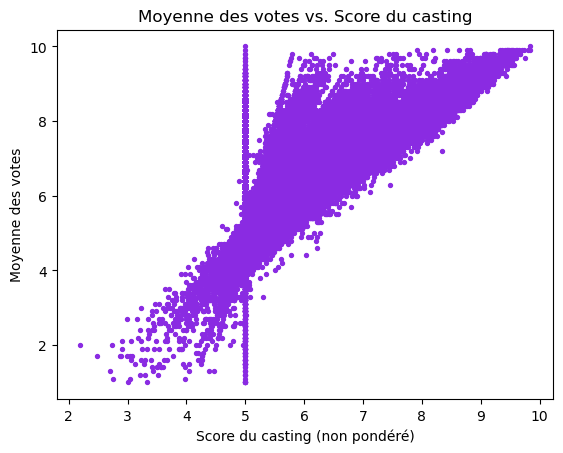

In [52]:
# corrélation score du cast (sans pondération) et note du film ?
def moyenne_scores(liste_scores) :
    if liste_scores != None :
        return np.mean(liste_scores)
    
df_fusionné2['score_cast_neutre'] = df_fusionné2['liste_scores'].apply(moyenne_scores)
df_fusionné2    

df_fusionné2.plot(x='score_cast_neutre', y='Note_moyenne', kind='scatter', s=8, c='#8A2BE2')
plt.title("Moyenne des votes vs. Score du casting")
plt.xlabel("Score du casting (non pondéré)")
plt.ylabel("Moyenne des votes")
plt.show()

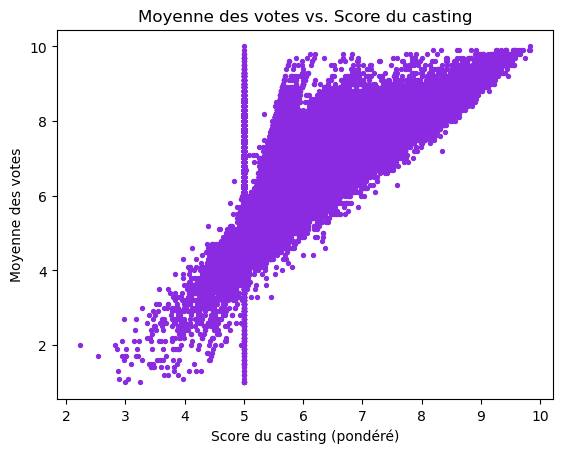

In [10]:
# corrélation score du cast (pondéré) et note du film ?
def moyenne_scores_pondérée (liste_scores) :
    moyenne_pondérée = 5
    if liste_scores != None :
        if len(liste_scores)==1 :
            moyenne_pondérée = liste_scores[0]
        else :
            moyenne_pondérée = 0
            n=2
            for i in liste_scores[:-1] :
                moyenne_pondérée += i/n
                n = 2*n
            moyenne_pondérée += liste_scores[-1]/(n/2)
    return moyenne_pondérée
    
df_fusionné2['score_cast_pondéré'] = df_fusionné2['liste_scores'].apply(moyenne_scores_pondérée)
df_fusionné2    

df_fusionné2.plot(x='score_cast_pondéré', y='Note_moyenne', kind='scatter', s=8, c='#8A2BE2')
plt.title("Moyenne des votes vs. Score du casting")
plt.xlabel("Score du casting (pondéré)")
plt.ylabel("Moyenne des votes")
plt.show()

In [56]:
#régression sur la note moyenne
df_regression = df_fusionné.copy()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_regression[['ID', 'duration', 'score_acteur', 'score_director']].dropna()
y = df_regression[['ID', 'Note_moyenne']].dropna()
df_filtrage = pd.merge(X, y, on='ID')

X = df_filtrage[['duration', 'score_acteur', 'score_director']]
y = df_filtrage['Note_moyenne'].dropna()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

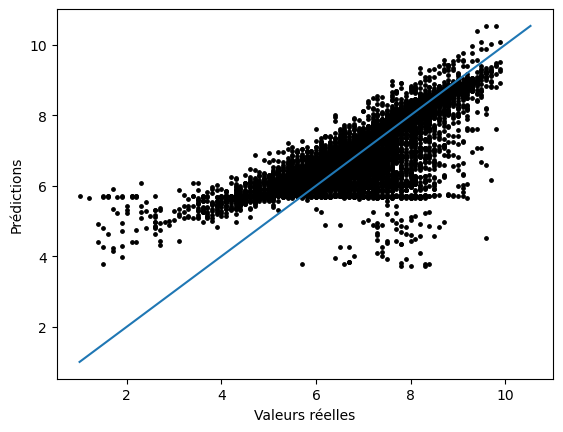

In [57]:
plt.scatter(y_test, y_pred, s=6, c='black')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])

In [58]:
#Régression sur le nb de votes
df_regression = df_fusionné.copy()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_regression[['ID', 'duration', 'score_acteur', 'score_director']].dropna()
y = df_regression[['ID', 'Nombre_de_votes']].dropna()
df_filtrage = pd.merge(X, y, on='ID')

X = df_filtrage[['duration', 'score_acteur', 'score_director']]
y = df_filtrage['Nombre_de_votes'].dropna()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

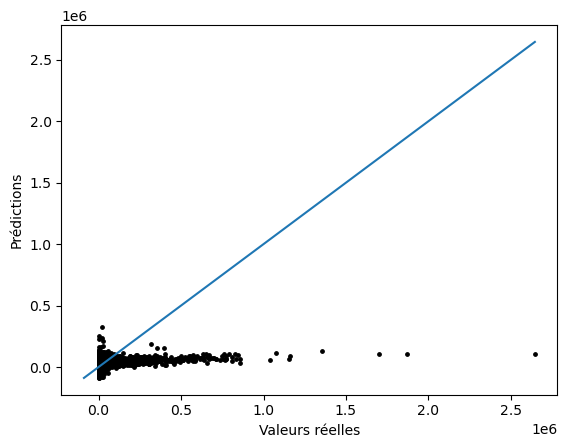

In [59]:
plt.scatter(y_test, y_pred, s=6, c='black')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])

In [60]:
def binariseur(df, nom_de_colonne):

    df = df.copy()# Créer une copie du dataframe

    if nom_de_colonne == 'genre' or nom_de_colonne == 'keywords': #pour les listes

      df_explosé_temp = df.explode (nom_de_colonne)

      Liste_elem_unique = df_explosé_temp[nom_de_colonne].unique() # je récupère la liste des éléments unique dans la colonne

      for element in Liste_elem_unique:

        df[element] = df[nom_de_colonne].apply(lambda x: 1 if element in x else 0) # nouvelle colonne avec un un ou un zéro

    else : 

      Liste_elem_unique = df[nom_de_colonne].unique() #si c'est pas des listes

    for element in Liste_elem_unique:

        df[element] = df[nom_de_colonne].apply(lambda x: 1 if element == x else 0)

        # Pour chaque élément unique,  je crée une nouvelle colonne dans la dataframe

    

    return df

In [61]:
binariseur(df_fusionné,'genre')

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,...,'Mystery','Biography','Film-Noir','Musical','News','Talk-Show','Adult','Game-Show','Reality-TV',
32016,tt2221420,Sallie Gardner at a Gallop,/title/tt2221420/,TV-G,1878-06-15,"['Documentary', 'Short']","['Gilbert Domm', 'Sallie Gardner']",['Eadweard Muybridge'],United States,1.0,...,0,0,0,0,0,0,0,0,0,0
14624,tt0392728,Roundhay Garden Scene,/title/tt0392728/,Not Rated,1888-10-14,"['Documentary', 'Short']","['Annie Hartley', 'Adolphe Le Prince', 'Joseph...",['Louis Aimé Augustin Le Prince'],United Kingdom,1.0,...,0,0,0,0,0,0,0,0,0,0
0,tt0000005,Blacksmith Scene,/title/tt0000005/,Unrated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,...,0,0,0,0,0,0,0,0,0,0
1,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,...,0,0,0,0,0,0,0,0,0,0
10983,tt0177707,Dickson Experimental Sound Film,/title/tt0177707/,Not Rated,1894-08-31,"['Short', 'Music']",['William K.L. Dickson'],['William K.L. Dickson'],United States,22.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26294,tt14208870,The Fabelmans,/title/tt14208870/,PG-13,2023-01-25,['Drama'],"['Michelle Williams', 'Gabriel LaBelle', 'Paul...",['Steven Spielberg'],France,151.0,...,0,0,0,0,0,0,0,0,0,0
26595,tt14444726,Tár,/title/tt14444726/,R,2023-02-22,"['Drama', 'Music']","['Cate Blanchett', 'Noémie Merlant', 'Nina Hoss']",['Todd Field'],France,158.0,...,0,0,0,0,0,0,0,0,0,0
25822,tt13833688,The Whale,/title/tt13833688/,R,2023-03-08,['Drama'],"['Brendan Fraser', 'Sadie Sink', 'Ty Simpkins']",['Darren Aronofsky'],France,117.0,...,0,0,0,0,0,0,0,0,0,0
39068,tt4960748,Till,/title/tt4960748/,PG-13,2023-03-22,"['Biography', 'Drama', 'History']","['Danielle Deadwyler', 'Jalyn Hall', 'Frankie ...",['Chinonye Chukwu'],France,130.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
from pandas.core.common import flatten

def valeurs_possibles (colonne) :
    list_nonflat = df_fusionné[colonne]
    flat_list = list(flatten(list_nonflat))
    liste_valeurs = list(set(flat_list))
    return liste_valeurs

In [63]:
def correcteur(colonne, old, new) :
    if type(df_fusionné[colonne][0]) == list :
        all_crews = []
        for crew in df_fusionné[colonne]:
            crew_corrigé = []
            if crew != [] :
                for individu in crew :
                    crew_corrigé.append(individu.replace(old, new))
            all_crews.append(crew_corrigé)
        df_fusionné[colonne] = all_crews
    else :
        df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)

In [64]:
correcteur('contentRating', 'Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tous public', 'tous publics')
correcteur('contentRating', 'Tous publics', 'tous publics')
correcteur('contentRating', 'Not Rated', 'Not rated') #Absence de certificat
correcteur('contentRating', 'Unrated', 'Not rated') #Idem
correcteur('contentRating', '-12', '12')
correcteur('contentRating', '10 avec avertissement', '10')
correcteur('contentRating', '12 avec avertissement', '12')
correcteur('contentRating', 'Passed', 'Approved') #Classification d'avant 1968
correcteur('contentRating', '14+', '14')
correcteur('contentRating', '(Banned)', 'Banned')
correcteur('contentRating', '-16', '16')
correcteur('contentRating', 'TV-14', '14')
correcteur('contentRating', '16 avec avertissement', '16')
correcteur('contentRating', '-10', '10')
correcteur('contentRating', 'TV-PG', 'Accord parental')
correcteur('contentRating', 'PG-13', 'Accord parental')
correcteur('contentRating', 'M/PG', 'Accord parental')
correcteur('contentRating', 'PG', 'Accord parental')
correcteur('contentRating', '0+', 'tous publics')
correcteur('contentRating', 'E1Tous Publics+', 'tous publics')
correcteur('contentRating', 'E1Tous Public+', 'tous publics')
correcteur('contentRating', 'TV-13', '13')
correcteur('contentRating', 'R', '18')
correcteur('contentRating', 'GP', 'Accord parental')
correcteur('contentRating', 'MA-17', '17')
correcteur('contentRating', 'X', '18')
correcteur('contentRating', 'TV-Y7-FV', '7')
correcteur('contentRating', 'TV-Y7', '7')
correcteur('contentRating', 'TV-G', 'Tous Public')
correcteur('contentRating', 'G', 'Tous Public')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tout public', 'tous publics')
correcteur('contentRating', '1Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Public+', 'tous publics')
correcteur('contentRating', 'NC-17', '18')
correcteur('contentRating', 'TV-MA', '18')
correcteur('contentRating', 'TV-T', 'tous publics')
correcteur('contentRating', 'M', '18')
correcteur('contentRating', 'E', 'Éducatif')
correcteur('contentRating', 'T', 'tous publics')
correcteur('contentRating', 'K-A', 'Erreur')
correcteur('contentRating', 'AO', 'Erreur')
correcteur('contentRating', 'Open', 'Erreur')
correcteur('contentRating', 'tous publicsV-Y', 'tous publics')
correcteur('contentRating', 'Éducatif1tous publics+', 'tous publics')
correcteur('contentRating', 'tous publicss avec avertissement', 'tous publics')
correcteur('contentRating', '1tous publics', 'tous publics')
correcteur('contentRating', 'tous publicss', 'tous publics')

/tmp/ipykernel_126/534507345.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)


In [65]:
valeurs_possibles('contentRating')

['tous publics+',
 '6+',
 '9+',
 '16',
 '17',
 nan,
 'Erreur',
 '14',
 '18',
 'Public Averti',
 '7',
 'Accord parental',
 '(Banned)',
 'Éducatif',
 'Approved',
 'Not rated',
 'tous publics',
 '13',
 '14+',
 '12']

32016    7.4
14624    7.3
0        6.2
1        5.4
10983    6.7
        ... 
26294    7.9
26595    7.8
25822    8.3
39068    7.2
27659    6.8
Name: Note_moyenne, Length: 46081, dtype: float64

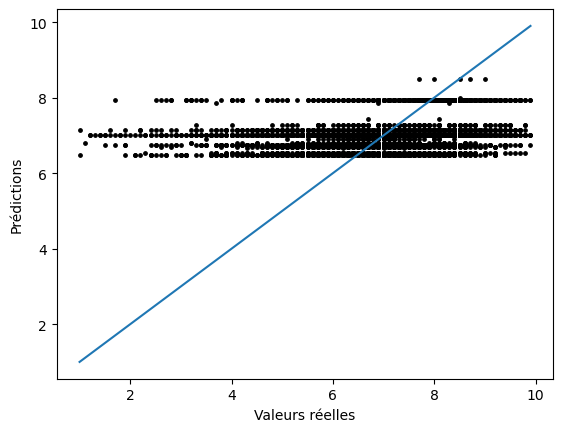

                            OLS Regression Results                            
Dep. Variable:           Note_moyenne   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                 4.036e+04
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:00:22   Log-Likelihood:                -62902.
No. Observations:               45952   AIC:                         1.258e+05
Df Residuals:                   45950   BIC:                         1.258e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.3388      0.024     99.399   

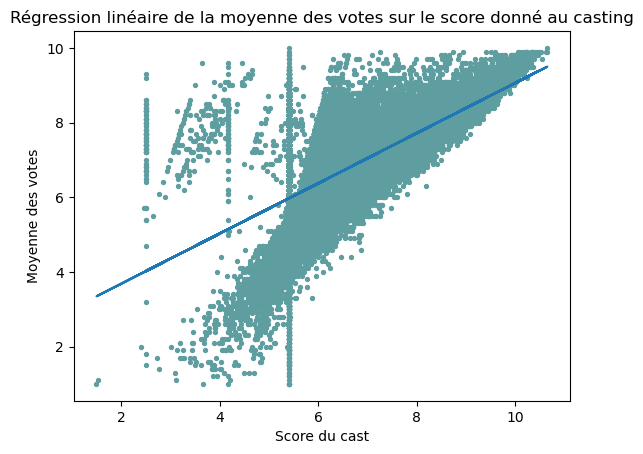

In [98]:
#superposition de la droite de régression obtenue juste au-dessus avec le nuage de points Moyenne des votes/Score_cast

def droite_reg(x):
    return 0.6720*x + 2.3388

df_fusionné.plot(x='score_acteur', y='Note_moyenne', kind='scatter', s=8, c='#5F9EA0')
plt.title("Régression linéaire de la moyenne des votes sur le score donné au casting")
plt.xlabel("Score du cast")
plt.ylabel("Moyenne des votes")

x = df_fusionné['score_acteur']
y2 = droite_reg(x)
plt.plot(x, y2)

plt.show()

In [86]:
def droite_reg(x):
    return 0.6720*x + 2.3388